# Daily step count and average monthly temperature in Iowa

In [1]:
import xml.etree.ElementTree
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from calendar import monthrange
FS = 16 # Font size for plots

### Load the Apple health data (step counts)

In [2]:
xDoc = xml.etree.ElementTree.parse('./data/apple_health_export/export.xml')
xRoot = xDoc.getroot()
items = list(xRoot)
step_type = 'HKQuantityTypeIdentifierStepCount'

In [4]:
tmp_step_data = []
for i,item in enumerate(items):
    if 'type' in item.attrib and item.attrib['type'] == step_type:       
        tmp_step_data.append((item.attrib['creationDate'], item.attrib['startDate'], item.attrib['endDate'], item.attrib['value']))

# Convert to data frame
all_step_data = pd.DataFrame(tmp_step_data, columns = ['creationDate','startDate','endDate','steps'])

# Convert step counts to numpy array
all_step_counts = np.array(all_step_data.values[:,-1], dtype=int)
all_step_dates  = np.array(all_step_data.values[:,0])
all_step_data.head()

,creationDate,startDate,endDate,steps
0,2017-05-20 14:04:32 -0500,2017-05-20 13:43:41 -0500,2017-05-20 13:50:53 -0500,29
1,2017-05-20 15:02:38 -0500,2017-05-20 13:59:30 -0500,2017-05-20 14:06:11 -0500,19
2,2017-05-20 15:02:38 -0500,2017-05-20 14:12:05 -0500,2017-05-20 14:19:39 -0500,50
3,2017-05-20 15:02:38 -0500,2017-05-20 14:19:39 -0500,2017-05-20 14:25:36 -0500,13
4,2017-05-20 15:02:38 -0500,2017-05-20 14:39:32 -0500,2017-05-20 14:45:32 -0500,5


#### Sum up step counts by day

In [5]:
steps_per_month, months_steps = [],[]
current_month = datetime.strptime(all_step_dates[0][:7], '%Y-%m')
running_step_count = 0
for n, date, step_count in zip(range(len(all_step_dates)), all_step_dates, all_step_counts):
    new_month = datetime.strptime(date[:7], '%Y-%m')
    
    if new_month > current_month or n == len(all_step_dates)-1:
        # How many days are in the current month?
        if date==all_step_dates[-1]:
            days_in_month = int(date[8:10])
        else:
            days_in_month = monthrange(current_month.year, current_month.month)[1]

        # Average step count for current month
        steps_per_month.append(running_step_count/days_in_month)
        months_steps.append(current_month.strftime('%b-%Y'))        
        
        # Reset the running step count and current month
        current_month = new_month
        running_step_count = step_count
    else:
        running_step_count += step_count    

# Convert to numpy arrays        
steps_per_month = np.array(steps_per_month)
months_steps = np.array(months_steps)

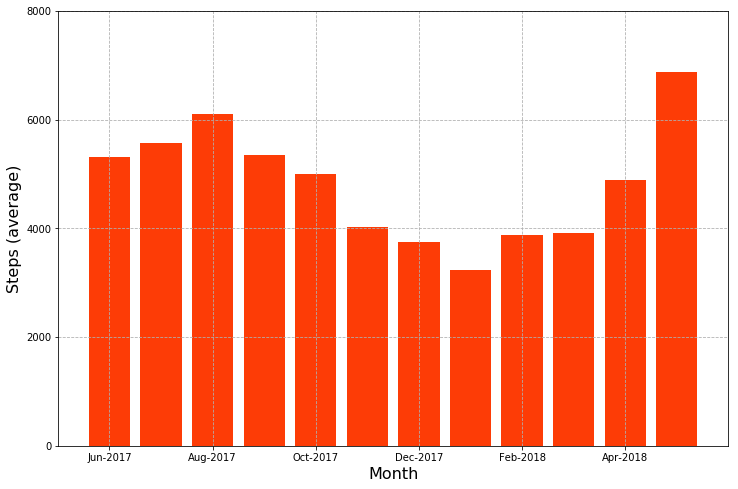

In [6]:
y = steps_per_month[1:]
x = np.arange(len(y))
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(x, y, color="xkcd:red orange")
ax.set_ylim((0,8000))
ax.set_xlabel("Month", fontsize=FS)
ax.set_ylabel("Steps (average)", fontsize=FS)
ax.set_yticks(np.arange(0,ax.get_ylim()[1]+1,2000))
ax.set_xticks(x[0:-1:2])
ax.set_xticklabels(months_steps[1:-1:2])
ax.grid(ls='dashed')
plt.show()

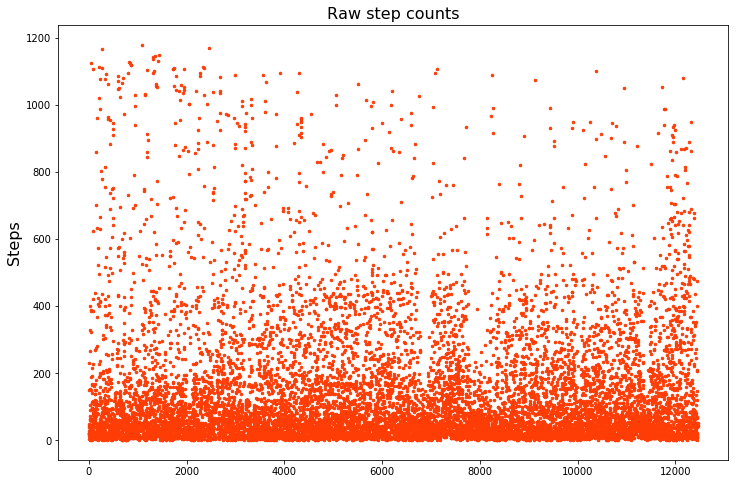

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(all_step_counts, '.', color='xkcd:red orange', markersize=5)
ax.set_ylabel("Steps", fontsize=FS)
ax.set_title("Raw step counts", fontsize=FS)
plt.show()
# plt.savefig("./figures/step_counts_raw.png", format='png', dpi=300)

## Load the weather data

In [9]:
# https://www.ncdc.noaa.gov/cag/city/time-series/USW00094910/tavg/all/4/2016-2018?base_prd=true&firstbaseyear=1901&lastbaseyear=2000
# https://www.usclimatedata.com/climate/iowa-city/iowa/united-states/usia0414/2017/2
filename = './data/AverageTemp_Waterloo_IA.csv'
temperature = np.genfromtxt(filename, delimiter=',', skip_header=5)
temperature = temperature[:,:3]
fun_format_date = lambda d: datetime.strptime(str(int(d)),'%Y%m').strftime('%b-%Y')
months_weather = list(map(fun_format_date, temperature[:,0]))

### Plot the weather data

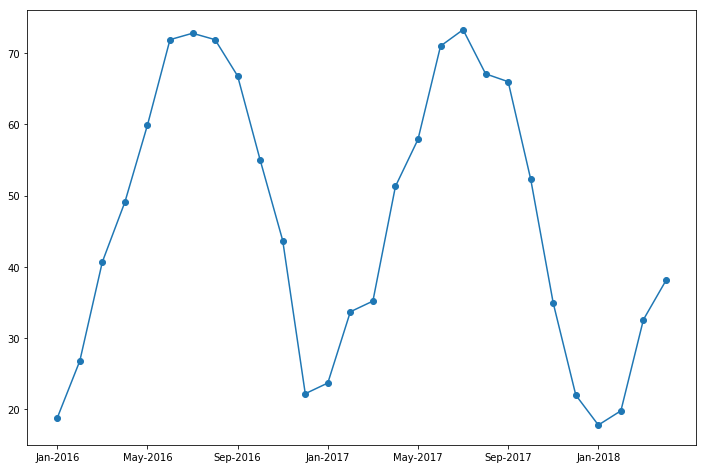

In [10]:
y = temperature[:,1]
x = np.arange(len(y))
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x, y, 'o-')
ax.set_xticks(x[0:-1:4])
ax.set_xticklabels(months_weather[0:-1:4])
plt.show()

# Combine the steps and weather data in one plot

In [11]:
# Find the overlapping indices
mask_months_weather = np.in1d(months_weather, months_steps)
mask_months_steps = np.in1d(months_steps, months_weather)

# Months that are common to both sources of data
months_both = np.intersect1d(months_weather, months_steps)
months_both

array(['Apr-2018', 'Aug-2017', 'Dec-2017', 'Feb-2018', 'Jan-2018',
       'Jul-2017', 'Jun-2017', 'Mar-2018', 'May-2017', 'Nov-2017',
       'Oct-2017', 'Sep-2017'], dtype='<U8')

In [62]:
# Specify the X and Y data for the plot
months_both = months_steps[mask_months_steps][1:]
y_step = steps_per_month[mask_months_steps][1:]
y_temp = temperature[mask_months_weather,1][1:]
x = np.arange(len(y_step))

### Make the combined plot

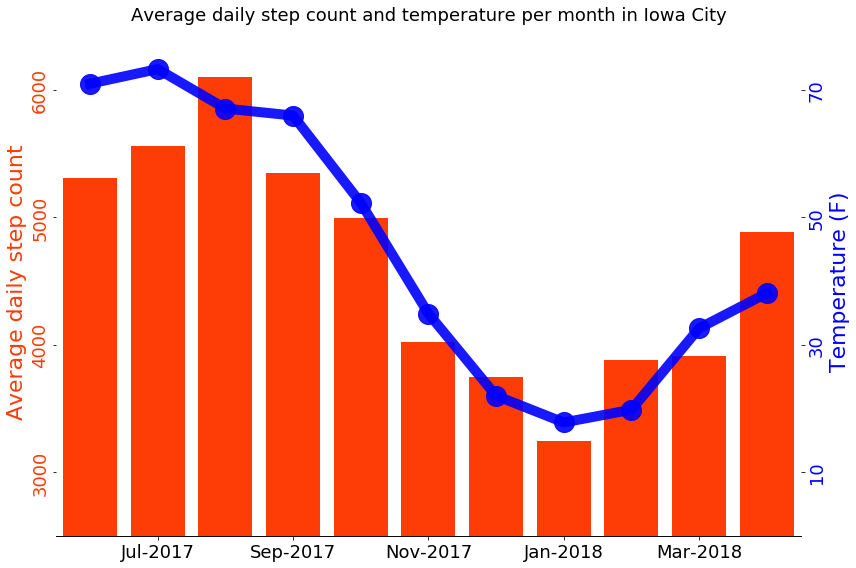

In [133]:
c1, c2 = 'xkcd:red orange', 'blue'
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()
ax1.bar(x, y_step, color=c1, label='Steps')
ax2.plot(x, y_temp, 'o-', color=c2, lw=10, ms=20, alpha=0.9, label='Weather')

ax1.set_xticks(x[1:-1:2])
ax1.set_xticklabels(months_both[1:-1:2])

ax1.set_ylim((2500,6500))
ax1.set_yticks(np.arange(3000,6001,1000))
ax2.set_ylim((0,80))
ax2.set_yticks(np.arange(10,71,20))


# Increase tick label font sizes
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_color(c1)
    tick.label.set_rotation('vertical')
    tick.label.set_verticalalignment('center')
for tick in ax2.yaxis.get_major_ticks():
    tick.label2.set_rotation('vertical')
    tick.label2.set_verticalalignment('center')
    
ax1.set_ylabel("Average daily step count",   fontsize=FS+6, color=c1)
ax2.set_ylabel("Temperature (F)", fontsize=FS+6, color=c2)

ax1.tick_params(labelsize=FS+2)
ax2.tick_params(labelsize=FS+2, labelcolor=c2)

for ax in [ax1,ax2]:
    [ax.spines[spine].set_visible(False) for spine in ['top','left','right']]
    
ax1.set_xlim((-0.5,10.5))    

ax1.set_title("Average daily step count and temperature per month in Iowa City", fontsize=FS+2)
# ax1.grid(axis='y', alpha=0.75, ls='dashed')

fig.tight_layout()
# plt.savefig("./figures/temperature_and_step_count.png", format='png', dpi=300)
plt.show()

In [122]:
help(tick.label.set_horizontalalignment)

Help on method set_horizontalalignment in module matplotlib.text:

set_horizontalalignment(align) method of matplotlib.text.Text instance
    Set the horizontal alignment to one of
    
    ACCEPTS: [ 'center' | 'right' | 'left' ]



In [119]:
help(tick.label.set_rotation)

Help on method set_rotation in module matplotlib.text:

set_rotation(s) method of matplotlib.text.Text instance
    Set the rotation of the text
    
    ACCEPTS: [ angle in degrees | 'vertical' | 'horizontal' ]



In [106]:
help(ax2.tick_params)

Help on method tick_params in module matplotlib.axes._base:

tick_params(axis='both', **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Change the appearance of ticks and tick labels.
    
    Parameters
    ----------
    axis : {'x', 'y', 'both'}, optional
        Which axis to apply the parameters to.
    
    Other Parameters
    ----------------
    
    axis : {'x', 'y', 'both'}
        Axis on which to operate; default is 'both'.
    
    reset : bool
        If *True*, set all parameters to defaults
        before processing other keyword arguments.  Default is
        *False*.
    
    which : {'major', 'minor', 'both'}
        Default is 'major'; apply arguments to *which* ticks.
    
    direction : {'in', 'out', 'inout'}
        Puts ticks inside the axes, outside the axes, or both.
    
    length : float
        Tick length in points.
    
    width : float
        Tick width in points.
    
    color : color
        Tick color; accepts any mpl color 

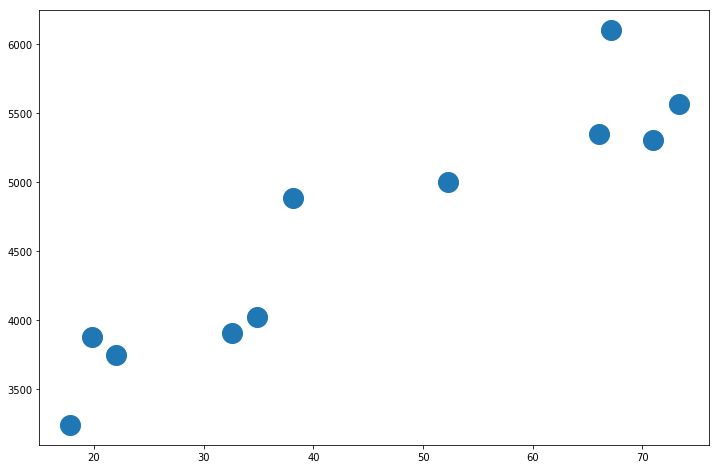

In [42]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(y_temp, y_step, 'o', ms=20)
plt.show()